In [1]:
import numpy as np
import qibo
from time import time
import matplotlib.pyplot as plt
from qibo import callbacks, gates, hamiltonians, models
from qibo.symbols import Y, Z, I
from sklearn.datasets import make_moons
from qibo.models import Circuit

#Se desactiva los mensajes de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

#Fijar el backend en el que se ejecutará el programa
qibo.set_backend("tensorflow")

[Qibo 0.1.12.dev0|INFO|2024-06-11 12:06:02]: Using tensorflow backend on /device:CPU:0


In [2]:
# Algunos hiperparámetros del sistema
nclasses=2 # Número de classes
measured_qubits= int(np.ceil(np.log2(nclasses))) #Número de qubits a medir(depende del numero de classes)
nqubits=2 # Número de qubits
nlayers=4 # Número de capas
nshots=10000 # Número de runs del circuito

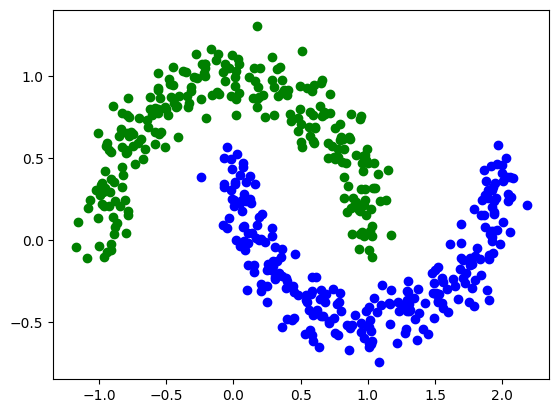

In [3]:
# Generamos el conjuto de datos con dos classes y lo mostramos en un gráfico
num_inputs = 2
num_samples = 500
X,y=make_moons(num_samples,noise=0.1)
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.show()

In [4]:
def procesdata(data):
    data=np.array(data) #Pasamos los datos a una array
    Min=data.min(axis=0)
    Max=data.max(axis=0)
    data=(2*data-Max-Min)*np.pi/(Max-Min) #Centramos y acotamos entre -1 y 1
    return data

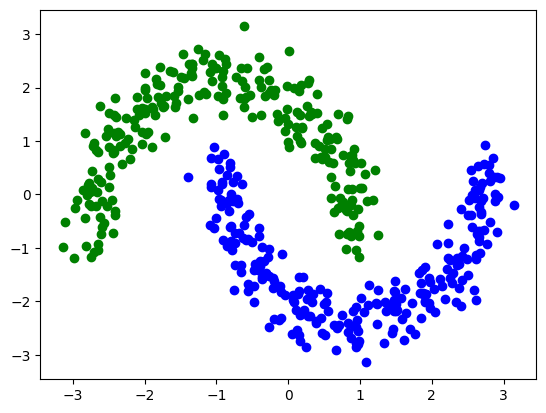

In [5]:
X_pad=procesdata(X)
Y = 2*y -np.ones(len(y)) #Cambaimos las etiquetas de cada datos de 0,1 a -1,1
for x, y_target in zip(X_pad, y): 
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.show()

In [6]:
num_train = int(0.80 * len(Y))
index = np.random.permutation(range(len(Y)))
Y_train = Y[index[:num_train]]
Y_val = Y[index[num_train:]]
X_train = X_pad[index[:num_train]]
X_val = X_pad[index[num_train:]]

In [7]:
def create_circuit(w,x, nqubits= 2,nlayers=nlayers):
    """
    Args:
        x: input del circuito
        w: parámetros del circuito
        nqubits: número de qubits
        nlayers: número de capas
    Returns:
        instancia de circuito cuántico para ejecutar
    """
    
    c= Circuit(nqubits=nqubits)

    c.add(gates.RY(q=0, theta = w[0]*x[0]))
    c.add(gates.RY(q=1, theta = w[1]*x[0]))
    
    c.add(gates.RZ(q=0, theta = w[2]*x[1]))
    c.add(gates.RZ(q=1, theta = w[3]*x[1]))
    
    for i in range(nlayers):
        j=i*4+3
        #j=7+i*4
        c.add(gates.RY(q=0, theta = w[j+1]))
        c.add(gates.RY(q=1, theta = w[j+2]))
     
        c.add(gates.CZ(0,1))
    
        c.add(gates.RY(q=0, theta = w[j+3]))
        c.add(gates.RY(q=1, theta = w[j+4]))
    
    # Última rotación
    c.add(gates.RY(q=0, theta = w[j+5]))
    c.add(gates.RY(q=1, theta = w[j+6]))
    
    c.add(gates.M(0))
    
    return c

In [8]:
#Definimos el observable que vamos a medir en este caso pauliz en el primer qubit
def hamiltonian(nqubits):
    if nqubits==1:
        Obj=Z(0)
    else:
        Obj = np.kron( Z(0), I(1))
    h = hamiltonians.SymbolicHamiltonian(Obj)
    return h

In [9]:
def Predictions(data, theta, nqubits, nshots=10000,R=False):
    """
    Args:
        data: input del circuito
        theta: parámetros del circuito
        nqubits: número de qubits
        nshots: número de shots 
        R= parámetro que controla si hacemos data reuploading
    Returns:
        numpy.array() con los valores esperados correspondientes al input
    """
    if R==True:
        c= create_circuitd(theta,data,nqubits)
        
    else:
        c =  create_circuit(theta,data, nqubits)
    h = hamiltonian(nqubits)
    expected_value = h.expectation(c.execute().state())
    return expected_value


In [10]:
def sqloss_acc(labels, predictions):
    sqloss = 0
    acc = 0
    for label, prediction in zip(labels, predictions):    
        sqloss = sqloss + (label - prediction)**2
        if np.sign(label)==np.sign(prediction):
            acc += 1
    sqloss = sqloss / len(labels)
    acc = acc / len(labels)
    print('Loss: ', sqloss.numpy(), 'Acc: ', acc)
    return sqloss, acc

In [11]:
def Cost_function(theta, data, Y, nqubits, nshots=10000,R=False):

    predictions = [Predictions(x, theta,nqubits,nshots,R) for x in data]

    return sqloss_acc(Y, predictions)[0]


In [12]:
#Inicializamos aleatoriamente los parametros
np.random.seed(0)
test_params = (np.pi* np.random.rand(2 * nqubits * nlayers + nqubits + 4))

#imprimimos los parametros
print('número de parámetros a ajustar:',len(test_params))
print('Parametros iniciales',test_params)

#pasamos los parametros a un tensor y comprovamos la fucnión de coste
params = tf.Variable(test_params,dtype=tf.complex128)
cost_all = Cost_function(params, X_pad, Y,nqubits)
#print('params',params)
print('cost_all',cost_all)

número de parámetros a ajustar: 22
Parametros iniciales [1.72414847 2.24683366 1.89363699 1.711801   1.33095081 2.0291362
 1.37472077 2.80158751 3.02743585 1.20461706 2.48727756 1.66157239
 1.78456462 2.9078476  0.22316636 0.27372477 0.06351797 2.61575239
 2.44465153 2.73322377 3.07442019 2.51063067]


Loss:  1.334702175654109 Acc:  0.506
cost_all tf.Tensor(1.334702175654109, shape=(), dtype=float64)


In [13]:
params=tf.Variable(np.array([ 1.15410294+0.j,  2.87684302+0.j,  2.6736488 +0.j,  0.84173673+0.j,
        1.15082887+0.j,  1.81912963+0.j,  1.40472511+0.j,  2.59156761+0.j,
        3.05744019+0.j,  0.99459716+0.j,  2.72729385+0.j,  1.90203343+0.j,
        2.02458091+0.j,  3.14830863+0.j, -0.0168414 +0.j,  0.48372381+0.j,
       -0.17648978+0.j,  2.82575143+0.j,  2.26463316+0.j,  2.73322377+0.j,
        2.89440183+0.j,  2.51063067+0.j]),dtype=tf.complex128)
params

<tf.Variable 'Variable:0' shape=(22,) dtype=complex128, numpy=
array([ 1.15410294+0.j,  2.87684302+0.j,  2.6736488 +0.j,  0.84173673+0.j,
        1.15082887+0.j,  1.81912963+0.j,  1.40472511+0.j,  2.59156761+0.j,
        3.05744019+0.j,  0.99459716+0.j,  2.72729385+0.j,  1.90203343+0.j,
        2.02458091+0.j,  3.14830863+0.j, -0.0168414 +0.j,  0.48372381+0.j,
       -0.17648978+0.j,  2.82575143+0.j,  2.26463316+0.j,  2.73322377+0.j,
        2.89440183+0.j,  2.51063067+0.j])>

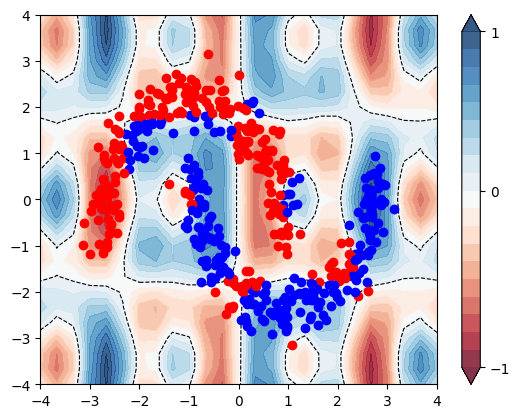

In [14]:
plt.figure()
cm = plt.cm.RdBu


xx, yy = np.meshgrid(np.linspace(-4, 4, 25), np.linspace(-4, 4, 25))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

#X_grid=procesdata(X_grid)

predictions_grid = [ Predictions(f, params, nqubits, nshots=nshots ) for f in X_grid]
Z1 = np.reshape(predictions_grid, xx.shape)


cnt = plt.contourf(
    xx, yy, Z1, levels=np.arange(-1, 1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z1, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

y2=[np.sign(Predictions(
            ket,
            params,
            nqubits,
            nshots=nshots,
            
        )) for ket in X_pad]
for x, y_target in zip(X_pad, y2):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "ro")
plt.show()

In [15]:
def create_circuitd(w,x, nqubits= 2,nlayers=nlayers):
    
    c= Circuit(nqubits=nqubits)
    for i in range(nlayers):
        c.add(gates.RY(q=0, theta = x[0]+w[2*i]))
        c.add(gates.RZ(q=0, theta = x[1]+w[2*i+1]))
    
    c.add(gates.M(0))
    
    return c

In [16]:
nclasses=2
measured_qubits= int(np.ceil(np.log2(nclasses)))
nqubits=1
nlayers=3
nshots=10000

In [17]:
num_data = len(Y)
num_train = int(0.80 * num_data)
index = np.random.permutation(range(num_data))
X_pad2=X_pad
Y_train = Y[index[:num_train]]
Y_val = Y[index[num_train:]]
X_train2 = X_pad2[index[:num_train]]
X_val = X_pad2[index[num_train:]]

In [18]:
#Inicializamos la variable
np.random.seed(0)
test_params = np.random.normal(0,1,8)*np.pi

print('número de parámetros a ajustar:',len(test_params))
print('test_params_INI',test_params)

#Pasamos la variable a un tensor
params = tf.Variable(test_params,dtype=tf.complex128)  
cost_all = Cost_function(params, X_pad2, Y,nqubits,R=True)

print('params',params)
print('cost_all',cost_all)

número de parámetros a ajustar: 8
test_params_INI [ 5.54193389  1.25713095  3.07479606  7.03997361  5.86710646 -3.07020901
  2.98479079 -0.47550269]


Loss:  2.039575553500645 Acc:  0.3
params <tf.Variable 'Variable:0' shape=(8,) dtype=complex128, numpy=
array([ 5.54193389+0.j,  1.25713095+0.j,  3.07479606+0.j,  7.03997361+0.j,
        5.86710646+0.j, -3.07020901+0.j,  2.98479079+0.j, -0.47550269+0.j])>
cost_all tf.Tensor(2.039575553500645, shape=(), dtype=float64)


In [19]:
paramsd=tf.Variable(np.array([ 6.98192218+0.j, -0.5428519 +0.j,  3.79479336+0.j,  8.11996204+0.j,
        5.50711014+0.j, -2.34991814+0.j,  2.44480601+0.j, -0.47550269+0.j]),dtype=tf.complex128)
paramsd

<tf.Variable 'Variable:0' shape=(8,) dtype=complex128, numpy=
array([ 6.98192218+0.j, -0.5428519 +0.j,  3.79479336+0.j,  8.11996204+0.j,
        5.50711014+0.j, -2.34991814+0.j,  2.44480601+0.j, -0.47550269+0.j])>

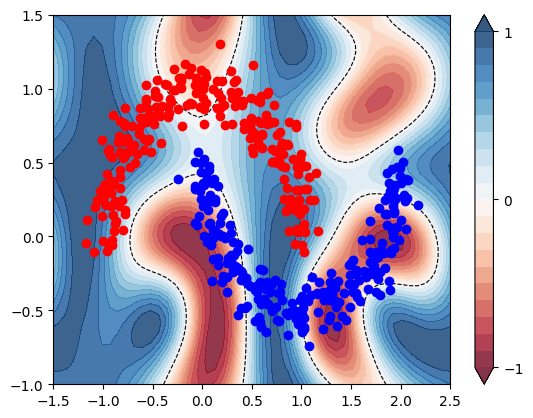

In [20]:
plt.figure()
cm = plt.cm.RdBu
paramsd=params

xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 50), np.linspace(-1, 1.5, 50))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

X_grid=procesdata(X_grid)

predictions_grid = [
            Predictions(
            f,
            paramsd,
            nqubits,
            nshots=nshots,
            R=True
        ) for f in X_grid]
Z2 = np.reshape(predictions_grid, xx.shape)


cnt = plt.contourf(
    xx, yy, Z2, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z2, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

y2=[Predictions(
            ket,
            paramsd,
            nqubits,
            nshots=nshots,
            R=True
        )
        for ket in X_pad2
    ]
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "ro")
plt.show()